# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cha     3690 non-null   float64
 1   level   3690 non-null   int64  
 2   dex     3690 non-null   float64
 3   con     3690 non-null   float64
 4   int     3690 non-null   float64
 5   wis     3690 non-null   float64
 6   ac      3690 non-null   float64
 7   hp      3690 non-null   int32  
 8   book    3690 non-null   object 
 9   str     3690 non-null   float64
dtypes: float64(7), int32(1), int64(1), object(1)
memory usage: 302.7+ KB


In [3]:
df.head()

,cha,level,dex,con,int,wis,ac,hp,book,str
0,0.0,9,3.0,0.0,0.0,3.0,28.0,155,Pathfinder #165: Eyes of Empty Death,6.0
1,0.0,10,3.0,6.0,0.0,3.0,30.0,175,Pathfinder Abomination Vaults Hardcover Compil...,7.0
2,1.0,2,3.0,1.0,-2.0,3.0,17.0,38,Pathfinder #164: Hands of the Devil,4.0
3,1.0,8,4.0,3.0,0.0,3.0,27.0,140,Pathfinder #164: Hands of the Devil,3.0
4,2.0,9,6.0,0.0,2.0,4.0,31.0,90,Pathfinder #165: Eyes of Empty Death,-5.0


###### Level

In [4]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


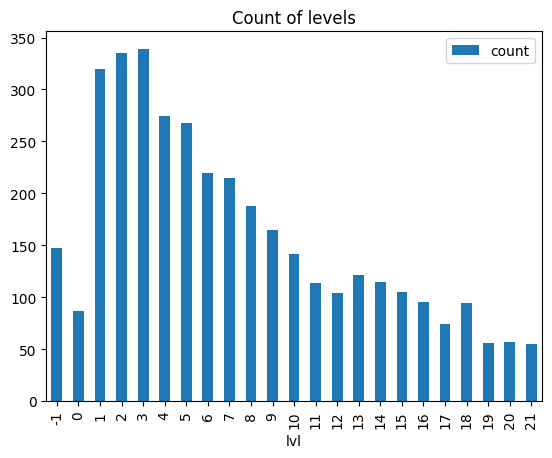

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 8
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.575491	valid_0's l1: 0.447891


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.76
MAE: 0.45


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.76


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

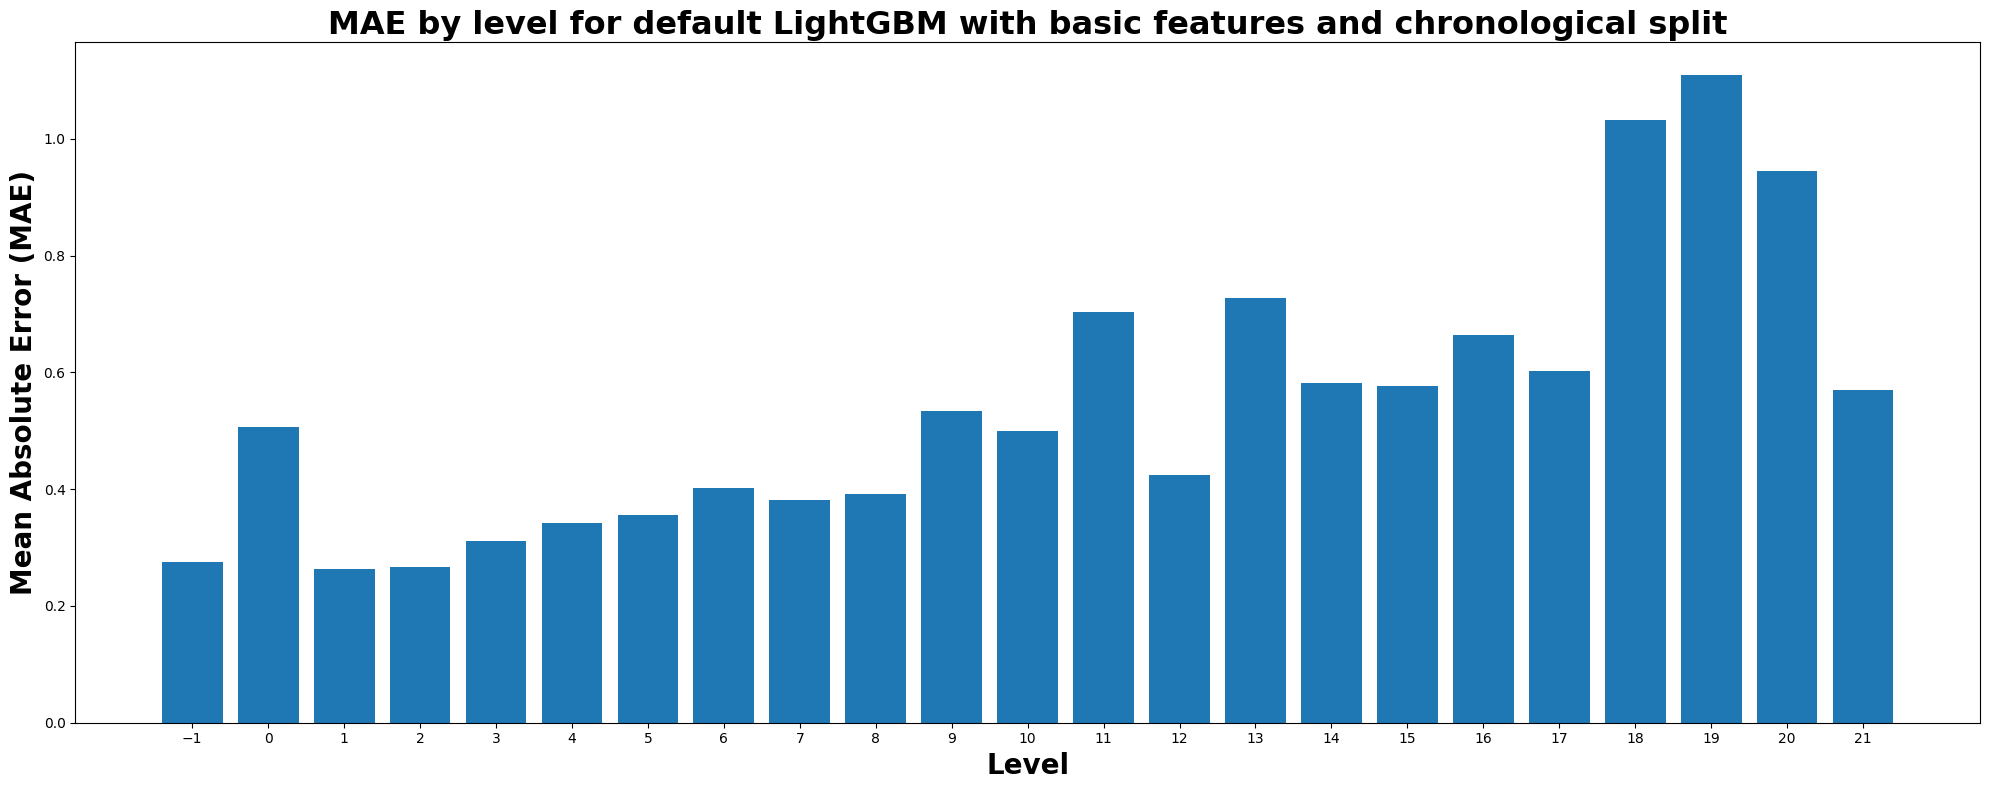

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.76

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.77

Round type: 0.45
RMSE: 0.77



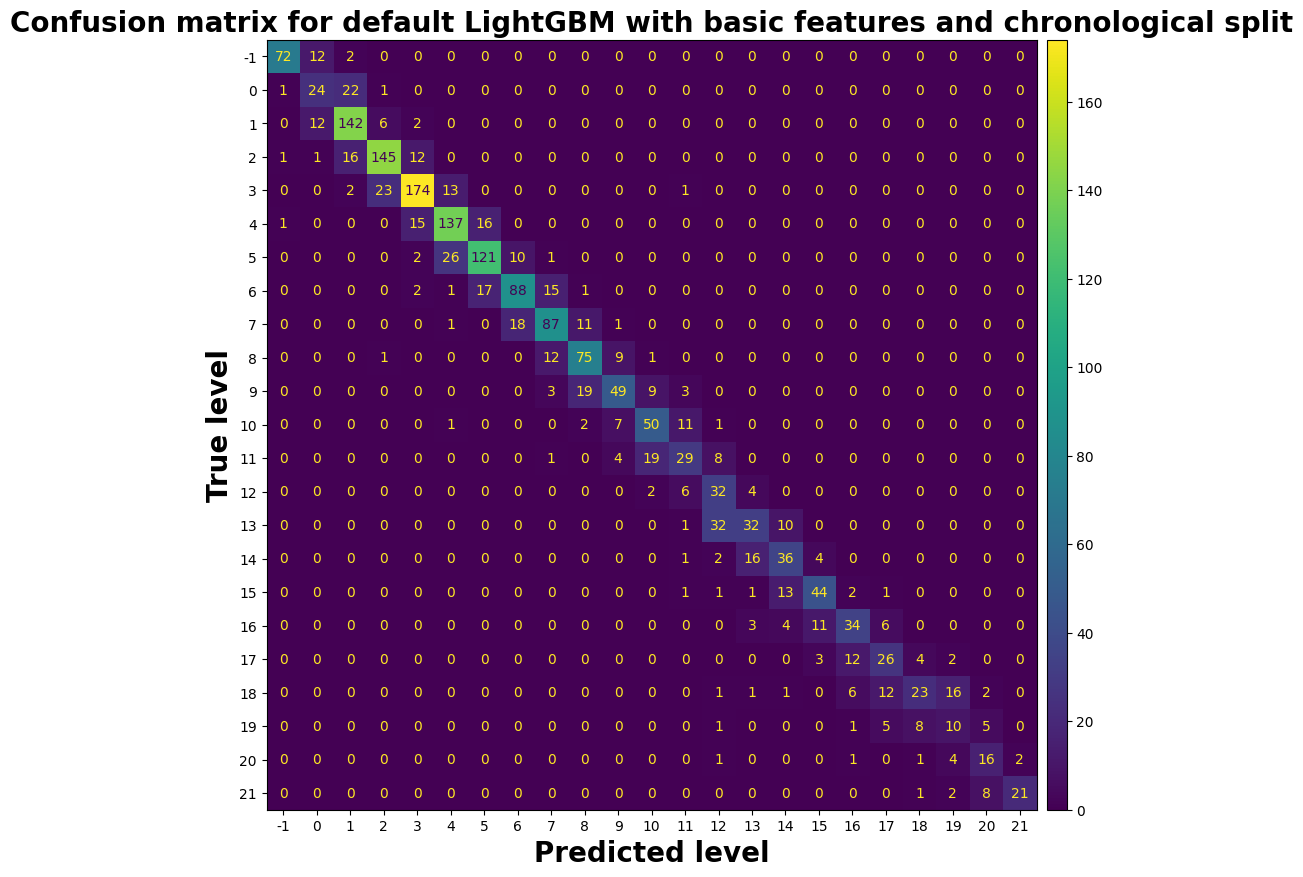

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-27 23:10:41,654] A new study created in memory with name: no-name-d1ea986e-bab1-483e-83f7-5d53e0293af2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.323738 + 0.182709
[200]	cv_agg's l2: 0.31911 + 0.172095


feature_fraction, val_score: 0.317795:  14%|#4        | 1/7 [00:05<00:31,  5.24s/it]

Early stopping, best iteration is:
[157]	cv_agg's l2: 0.317795 + 0.174618
[100]	cv_agg's l2: 0.287998 + 0.151042
[200]	cv_agg's l2: 0.2939 + 0.146338


feature_fraction, val_score: 0.286608:  29%|##8       | 2/7 [00:08<00:20,  4.09s/it]

Early stopping, best iteration is:
[115]	cv_agg's l2: 0.286608 + 0.149181
[100]	cv_agg's l2: 0.287998 + 0.151042
[200]	cv_agg's l2: 0.2939 + 0.146338
Early stopping, best iteration is:
[115]	cv_agg's l2: 0.286608 + 0.149181


feature_fraction, val_score: 0.286608:  43%|####2     | 3/7 [00:12<00:15,  3.99s/it]

[100]	cv_agg's l2: 0.432205 + 0.25431
[200]	cv_agg's l2: 0.387777 + 0.21973


feature_fraction, val_score: 0.286608:  57%|#####7    | 4/7 [00:17<00:13,  4.35s/it]

Early stopping, best iteration is:
[115]	cv_agg's l2: 0.286608 + 0.149181
[100]	cv_agg's l2: 0.2843 + 0.141929


feature_fraction, val_score: 0.284082:  71%|#######1  | 5/7 [00:20<00:08,  4.02s/it]

[200]	cv_agg's l2: 0.293002 + 0.141371
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.284082 + 0.141705
[100]	cv_agg's l2: 0.2902 + 0.141111


feature_fraction, val_score: 0.284082:  86%|########5 | 6/7 [00:23<00:03,  3.55s/it]

[200]	cv_agg's l2: 0.296659 + 0.138289
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.284082 + 0.141705
[100]	cv_agg's l2: 0.443736 + 0.288109


feature_fraction, val_score: 0.284082: 100%|##########| 7/7 [00:26<00:00,  3.79s/it]


[200]	cv_agg's l2: 0.403519 + 0.255589
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.284082 + 0.141705


num_leaves, val_score: 0.284082:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.286822 + 0.140276


num_leaves, val_score: 0.284082:   5%|5         | 1/20 [00:02<00:44,  2.36s/it]

[200]	cv_agg's l2: 0.291001 + 0.140248
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.284082 + 0.141705
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.282844:  10%|#         | 2/20 [00:05<00:52,  2.89s/it]

Early stopping, best iteration is:
[94]	cv_agg's l2: 0.282844 + 0.139051
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.282844:  15%|#5        | 3/20 [00:10<01:03,  3.72s/it]

Early stopping, best iteration is:
[94]	cv_agg's l2: 0.282844 + 0.139051
[100]	cv_agg's l2: 0.279011 + 0.138786


num_leaves, val_score: 0.278946:  20%|##        | 4/20 [00:12<00:47,  2.94s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.338785 + 0.133471


num_leaves, val_score: 0.278946:  25%|##5       | 5/20 [00:12<00:31,  2.08s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  30%|###       | 6/20 [00:16<00:36,  2.59s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  35%|###5      | 7/20 [00:19<00:38,  2.96s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  40%|####      | 8/20 [00:24<00:41,  3.46s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  45%|####5     | 9/20 [00:28<00:39,  3.55s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  50%|#####     | 10/20 [00:32<00:36,  3.68s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.285964 + 0.139906


num_leaves, val_score: 0.278946:  55%|#####5    | 11/20 [00:35<00:32,  3.57s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  60%|######    | 12/20 [00:39<00:28,  3.57s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.292772 + 0.134011


num_leaves, val_score: 0.278946:  65%|######5   | 13/20 [00:39<00:18,  2.69s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  70%|#######   | 14/20 [00:43<00:17,  2.92s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  75%|#######5  | 15/20 [00:46<00:15,  3.11s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  80%|########  | 16/20 [00:50<00:13,  3.31s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  85%|########5 | 17/20 [00:54<00:10,  3.57s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.285214 + 0.137936


num_leaves, val_score: 0.278946:  90%|######### | 18/20 [00:57<00:06,  3.31s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946:  95%|#########5| 19/20 [01:03<00:04,  4.09s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892
[100]	cv_agg's l2: 0.283583 + 0.138816


num_leaves, val_score: 0.278946: 100%|##########| 20/20 [01:10<00:00,  3.53s/it]


Early stopping, best iteration is:
[99]	cv_agg's l2: 0.278946 + 0.13892


bagging, val_score: 0.278946:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.273043 + 0.13286


bagging, val_score: 0.271074:  10%|#         | 1/10 [00:01<00:13,  1.49s/it]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.279077 + 0.134147
[200]	cv_agg's l2: 0.283118 + 0.136031
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


bagging, val_score: 0.271074:  20%|##        | 2/10 [00:02<00:10,  1.30s/it]

[100]	cv_agg's l2: 0.273803 + 0.136682


bagging, val_score: 0.271074:  30%|###       | 3/10 [00:03<00:08,  1.18s/it]

[200]	cv_agg's l2: 0.277449 + 0.134904
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.277629 + 0.138827


bagging, val_score: 0.271074:  40%|####      | 4/10 [00:04<00:06,  1.03s/it]

[200]	cv_agg's l2: 0.279511 + 0.13768
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.275922 + 0.134507


bagging, val_score: 0.271074:  50%|#####     | 5/10 [00:05<00:04,  1.04it/s]

[200]	cv_agg's l2: 0.279517 + 0.131721
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.279207 + 0.135611


bagging, val_score: 0.271074:  60%|######    | 6/10 [00:06<00:03,  1.02it/s]

[200]	cv_agg's l2: 0.281666 + 0.134819
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.279269 + 0.134509


bagging, val_score: 0.271074:  70%|#######   | 7/10 [00:07<00:02,  1.11it/s]

[200]	cv_agg's l2: 0.283628 + 0.131885
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.27461 + 0.138413


bagging, val_score: 0.271074:  80%|########  | 8/10 [00:07<00:01,  1.17it/s]

[200]	cv_agg's l2: 0.280324 + 0.140609
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.278809 + 0.135792


bagging, val_score: 0.271074:  90%|######### | 9/10 [00:09<00:00,  1.05it/s]

[200]	cv_agg's l2: 0.27843 + 0.12936
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.300867 + 0.140647


bagging, val_score: 0.271074: 100%|##########| 10/10 [00:09<00:00,  1.01it/s]


[200]	cv_agg's l2: 0.296252 + 0.13099
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


feature_fraction_stage2, val_score: 0.271074:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.273043 + 0.13286


feature_fraction_stage2, val_score: 0.271074:  17%|#6        | 1/6 [00:00<00:04,  1.16it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


feature_fraction_stage2, val_score: 0.271074:  33%|###3      | 2/6 [00:02<00:04,  1.04s/it]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.277251 + 0.136257


feature_fraction_stage2, val_score: 0.271074:  50%|#####     | 3/6 [00:02<00:02,  1.02it/s]

[200]	cv_agg's l2: 0.281392 + 0.133467
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286
[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


feature_fraction_stage2, val_score: 0.271074:  67%|######6   | 4/6 [00:04<00:02,  1.03s/it]

[100]	cv_agg's l2: 0.277251 + 0.136257


feature_fraction_stage2, val_score: 0.271074:  83%|########3 | 5/6 [00:04<00:00,  1.01it/s]

[200]	cv_agg's l2: 0.281392 + 0.133467
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


feature_fraction_stage2, val_score: 0.271074: 100%|##########| 6/6 [00:05<00:00,  1.03it/s]


[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


regularization_factors, val_score: 0.271074:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:   5%|5         | 1/20 [00:00<00:16,  1.13it/s]

[200]	cv_agg's l2: 0.276887 + 0.130604
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.290678 + 0.129683


regularization_factors, val_score: 0.271074:  10%|#         | 2/20 [00:01<00:15,  1.13it/s]

[200]	cv_agg's l2: 0.286562 + 0.127288
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  15%|#5        | 3/20 [00:02<00:16,  1.04it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.286723 + 0.133918


regularization_factors, val_score: 0.271074:  20%|##        | 4/20 [00:03<00:15,  1.05it/s]

[200]	cv_agg's l2: 0.283378 + 0.132016
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273855 + 0.132484


regularization_factors, val_score: 0.271074:  25%|##5       | 5/20 [00:04<00:14,  1.02it/s]

[200]	cv_agg's l2: 0.276777 + 0.131319
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.285838 + 0.133136


regularization_factors, val_score: 0.271074:  30%|###       | 6/20 [00:05<00:14,  1.05s/it]

[200]	cv_agg's l2: 0.282408 + 0.131795
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273522 + 0.134401


regularization_factors, val_score: 0.271074:  35%|###5      | 7/20 [00:07<00:14,  1.14s/it]

[200]	cv_agg's l2: 0.278035 + 0.130448
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  40%|####      | 8/20 [00:08<00:13,  1.14s/it]

[200]	cv_agg's l2: 0.276887 + 0.130604
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  45%|####5     | 9/20 [00:09<00:12,  1.12s/it]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  50%|#####     | 10/20 [00:10<00:10,  1.02s/it]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  55%|#####5    | 11/20 [00:11<00:08,  1.04it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.275905 + 0.134375


regularization_factors, val_score: 0.271074:  60%|######    | 12/20 [00:12<00:07,  1.06it/s]

[200]	cv_agg's l2: 0.279096 + 0.132375
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.274628 + 0.133881


regularization_factors, val_score: 0.271074:  65%|######5   | 13/20 [00:13<00:06,  1.01it/s]

[200]	cv_agg's l2: 0.279976 + 0.132352
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  70%|#######   | 14/20 [00:13<00:05,  1.06it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  75%|#######5  | 15/20 [00:14<00:04,  1.05it/s]

[200]	cv_agg's l2: 0.276405 + 0.130949
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  80%|########  | 16/20 [00:15<00:03,  1.08it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.272732 + 0.132588


regularization_factors, val_score: 0.271074:  85%|########5 | 17/20 [00:16<00:02,  1.14it/s]

[200]	cv_agg's l2: 0.274355 + 0.131659
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  90%|######### | 18/20 [00:17<00:01,  1.20it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074:  95%|#########5| 19/20 [00:18<00:00,  1.13it/s]

[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.273043 + 0.13286


regularization_factors, val_score: 0.271074: 100%|##########| 20/20 [00:19<00:00,  1.04it/s]


[200]	cv_agg's l2: 0.276409 + 0.130982
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


min_data_in_leaf, val_score: 0.271074:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.31054 + 0.141191


min_data_in_leaf, val_score: 0.271074:  20%|##        | 1/5 [00:01<00:04,  1.19s/it]

[200]	cv_agg's l2: 0.310451 + 0.135637
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.449661 + 0.210698


min_data_in_leaf, val_score: 0.271074:  40%|####      | 2/5 [00:01<00:02,  1.23it/s]

[200]	cv_agg's l2: 0.446693 + 0.212284
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.281693 + 0.124512


min_data_in_leaf, val_score: 0.271074:  60%|######    | 3/5 [00:02<00:01,  1.32it/s]

[200]	cv_agg's l2: 0.290666 + 0.122855
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.277057 + 0.132492


min_data_in_leaf, val_score: 0.271074:  80%|########  | 4/5 [00:03<00:00,  1.31it/s]

[200]	cv_agg's l2: 0.279151 + 0.129516
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416
[100]	cv_agg's l2: 0.280378 + 0.130623


min_data_in_leaf, val_score: 0.271074: 100%|##########| 5/5 [00:03<00:00,  1.27it/s]

[200]	cv_agg's l2: 0.286731 + 0.1261
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.271074 + 0.132416


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.2710735010791866
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 16
    feature_fraction: 0.8999999999999999
    bagging_fraction: 0.9866027667146993
    bagging_freq: 4
    min_child_samples: 20


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.02
RMSE test: 0.75
MAE test: 0.45



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

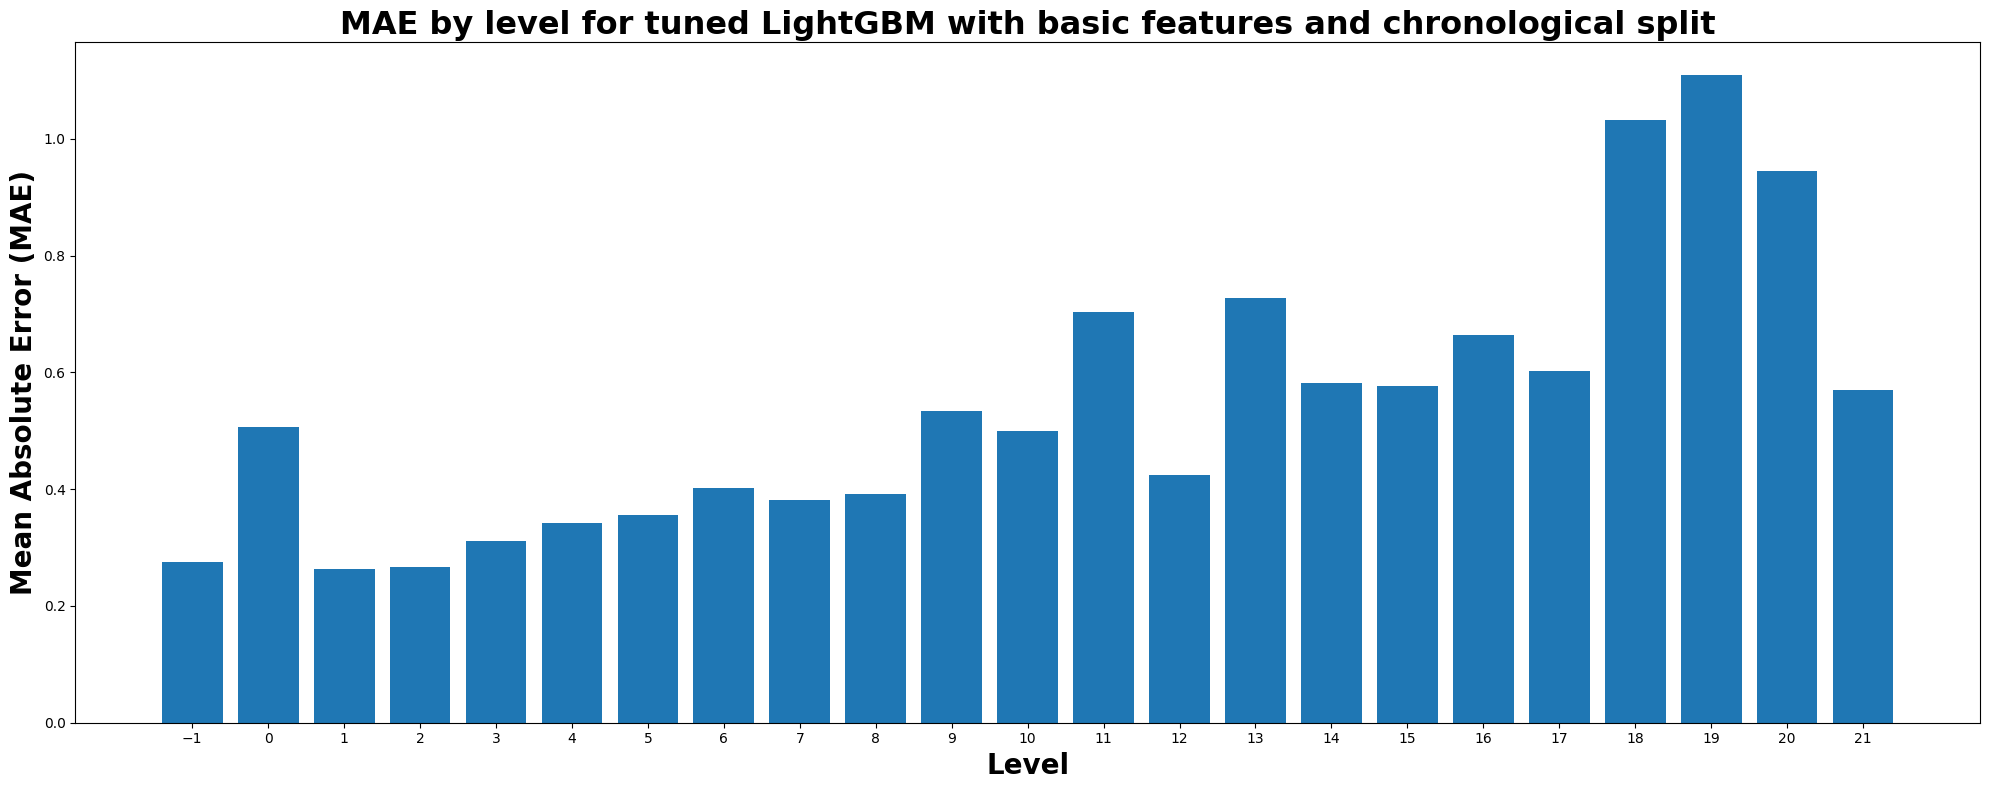

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.75

Round type: 0.5
RMSE: 0.77

Round type: 0.33
RMSE: 0.78

Round type: 0.45
RMSE: 0.77



In [30]:
predict[predict < -1] = -1
predict[predict > 21] = 21

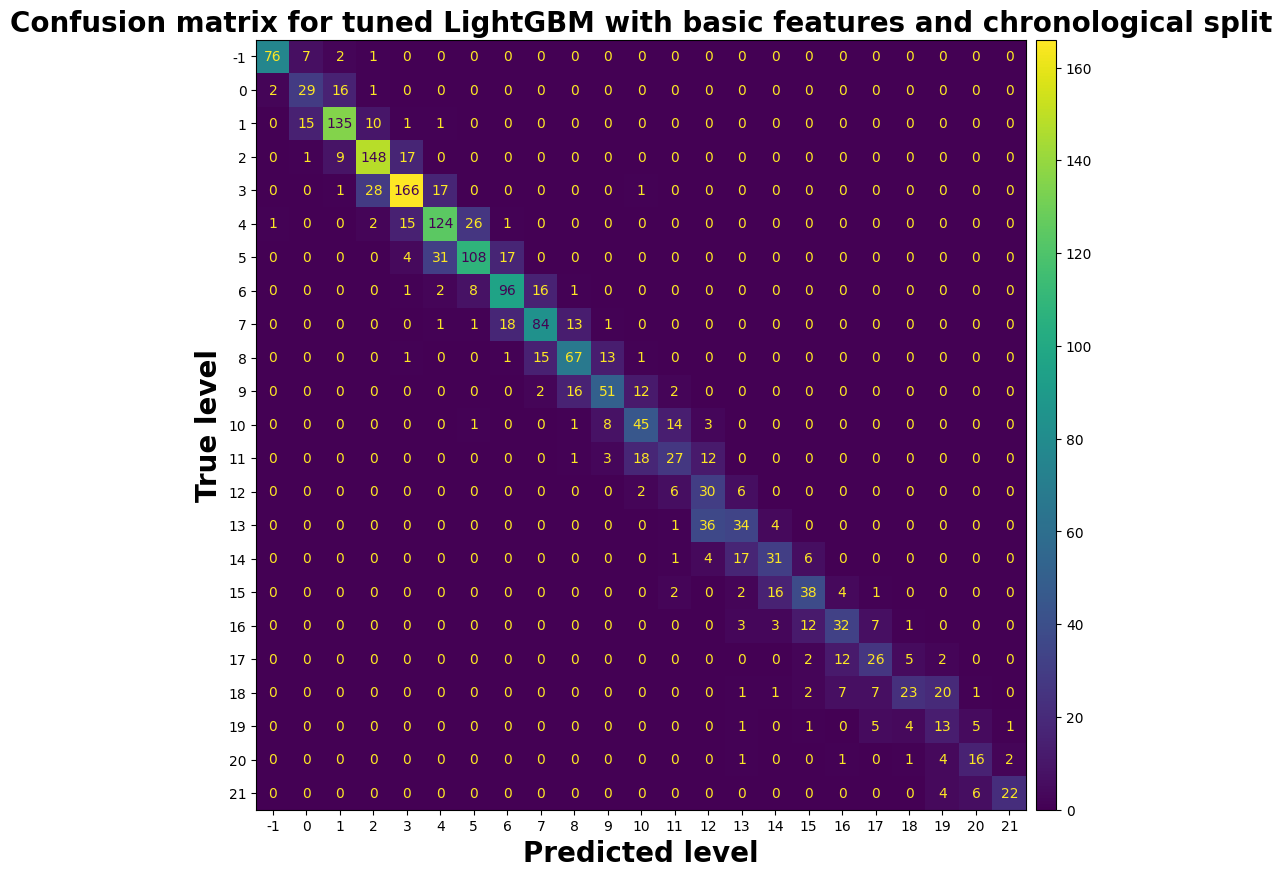

In [31]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 8
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.322742	valid_0's l1: 0.368391


In [33]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.57
MAE: 0.37


In [35]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

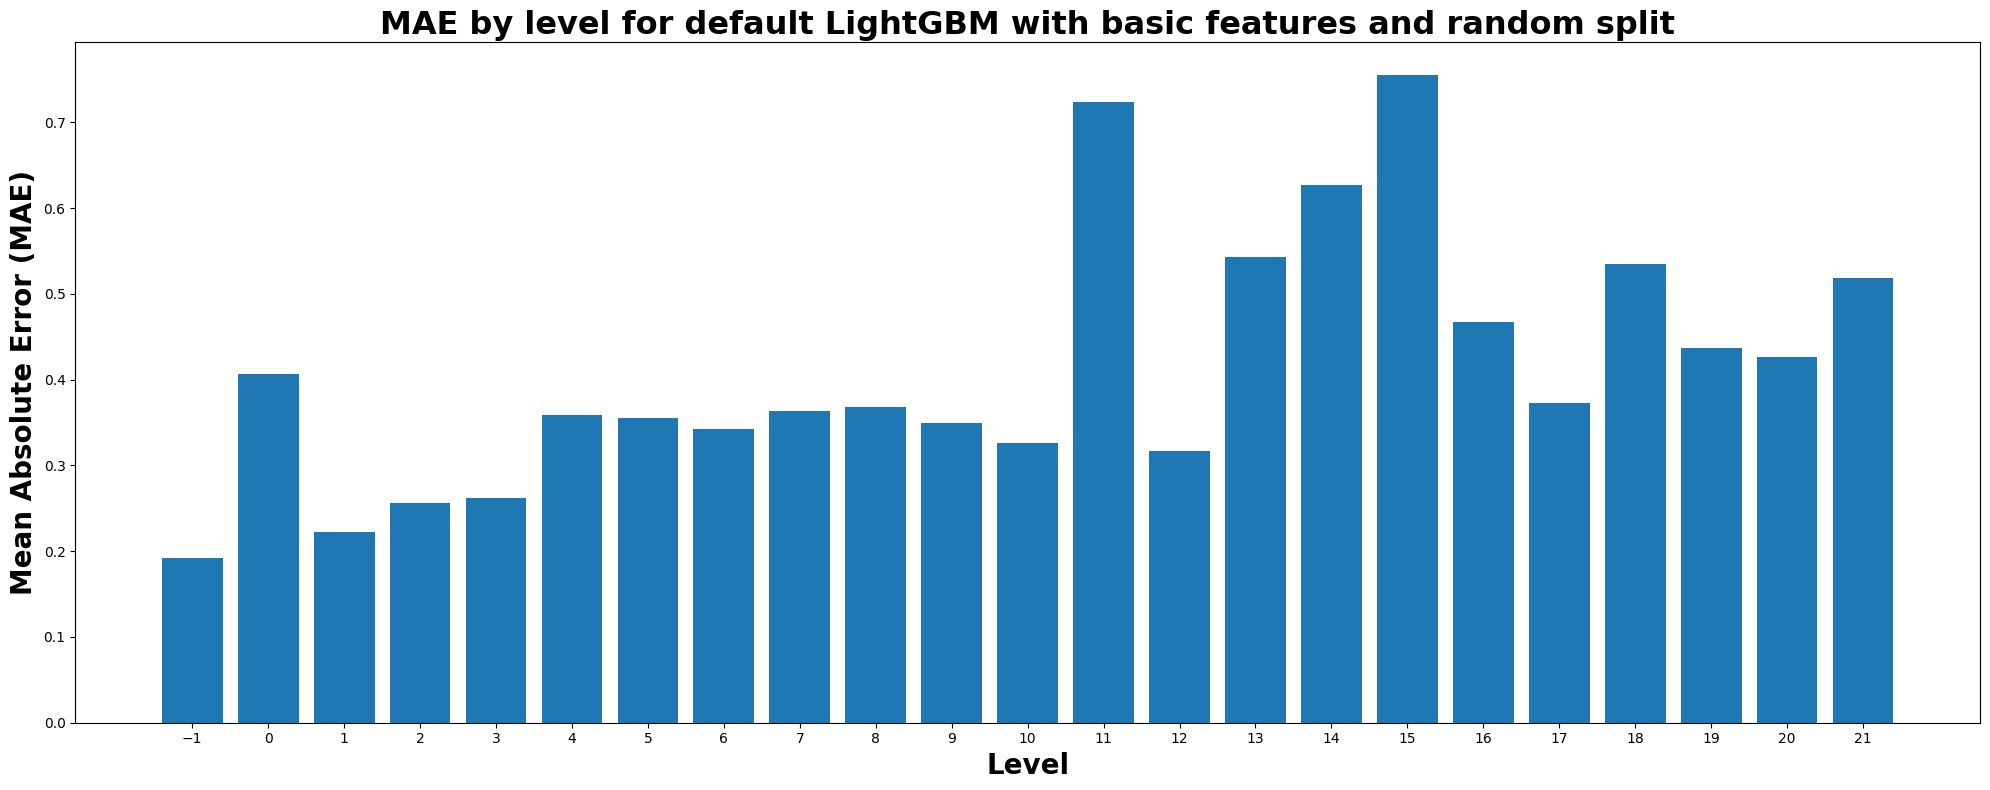

In [36]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [37]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.57

Round type: 0.5
RMSE: 0.60

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.60



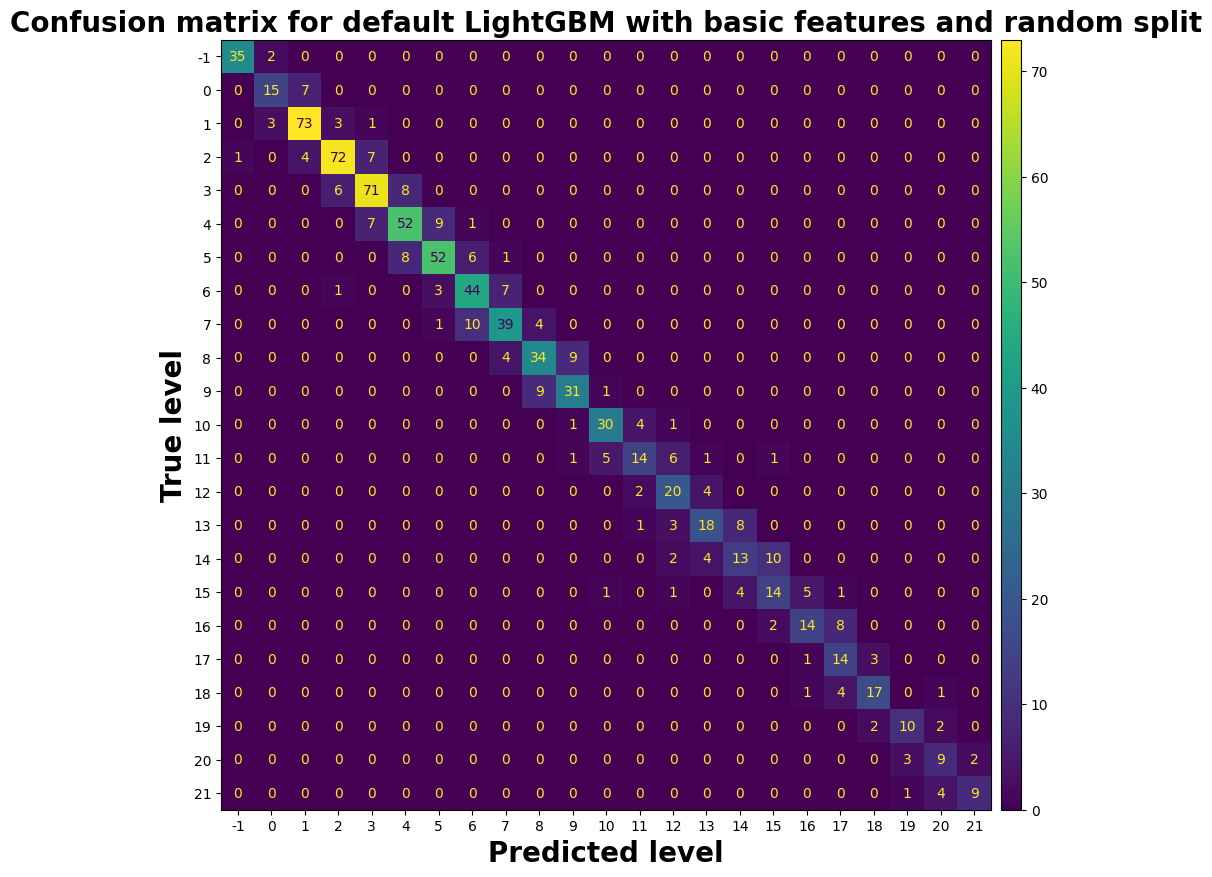

In [38]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [39]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-27 23:16:59,919] A new study created in memory with name: no-name-0f434363-b686-4cd0-bb68-4f196dd91a7e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.394264 + 0.116915


feature_fraction, val_score: 0.390801:  14%|#4        | 1/7 [00:01<00:05,  1.00it/s]

[200]	cv_agg's l2: 0.393666 + 0.110216
Early stopping, best iteration is:
[143]	cv_agg's l2: 0.390801 + 0.11303
[100]	cv_agg's l2: 0.390253 + 0.123896
[200]	cv_agg's l2: 0.389249 + 0.121337


feature_fraction, val_score: 0.388709:  29%|##8       | 2/7 [00:02<00:05,  1.14s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.388709 + 0.1213
[100]	cv_agg's l2: 0.385743 + 0.0984081
[200]	cv_agg's l2: 0.382914 + 0.0998681


feature_fraction, val_score: 0.382658:  43%|####2     | 3/7 [00:03<00:04,  1.23s/it]

[300]	cv_agg's l2: 0.38504 + 0.0997276
Early stopping, best iteration is:
[203]	cv_agg's l2: 0.382658 + 0.09981
[100]	cv_agg's l2: 0.375648 + 0.104688
[200]	cv_agg's l2: 0.375001 + 0.104852


feature_fraction, val_score: 0.374037:  57%|#####7    | 4/7 [00:04<00:03,  1.16s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.375648 + 0.104688
[200]	cv_agg's l2: 0.375001 + 0.104852
Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887


feature_fraction, val_score: 0.374037:  71%|#######1  | 5/7 [00:05<00:02,  1.13s/it]

[100]	cv_agg's l2: 0.472937 + 0.0764789
[200]	cv_agg's l2: 0.426361 + 0.0780712
Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887


feature_fraction, val_score: 0.374037:  86%|########5 | 6/7 [00:06<00:01,  1.05s/it]

[100]	cv_agg's l2: 0.461555 + 0.0851645
[200]	cv_agg's l2: 0.425002 + 0.0884427


feature_fraction, val_score: 0.374037: 100%|##########| 7/7 [00:07<00:00,  1.12s/it]


Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887


num_leaves, val_score: 0.374037:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:   5%|5         | 1/20 [00:02<00:48,  2.58s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.378295 + 0.11151
[200]	cv_agg's l2: 0.381493 + 0.108865


num_leaves, val_score: 0.374037:  10%|#         | 2/20 [00:04<00:41,  2.32s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  15%|#5        | 3/20 [00:07<00:41,  2.45s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  20%|##        | 4/20 [00:10<00:45,  2.82s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.402577 + 0.105076
[200]	cv_agg's l2: 0.390741 + 0.100086


num_leaves, val_score: 0.374037:  25%|##5       | 5/20 [00:11<00:30,  2.02s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  30%|###       | 6/20 [00:14<00:32,  2.35s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.49652 + 0.109017


num_leaves, val_score: 0.374037:  35%|###5      | 7/20 [00:14<00:21,  1.69s/it]

[200]	cv_agg's l2: 0.450972 + 0.0998138
Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  40%|####      | 8/20 [00:17<00:24,  2.01s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  45%|####5     | 9/20 [00:19<00:23,  2.15s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.383236 + 0.110074
[200]	cv_agg's l2: 0.388046 + 0.110864


num_leaves, val_score: 0.374037:  50%|#####     | 10/20 [00:22<00:24,  2.41s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  55%|#####5    | 11/20 [00:26<00:23,  2.66s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.379675 + 0.113537
[200]	cv_agg's l2: 0.38177 + 0.108693


num_leaves, val_score: 0.374037:  60%|######    | 12/20 [00:28<00:21,  2.72s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.379852 + 0.112415
[200]	cv_agg's l2: 0.379486 + 0.110451


num_leaves, val_score: 0.374037:  65%|######5   | 13/20 [00:31<00:17,  2.56s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.374037:  70%|#######   | 14/20 [00:36<00:20,  3.42s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.380326 + 0.108897
[200]	cv_agg's l2: 0.38274 + 0.106915


num_leaves, val_score: 0.374037:  75%|#######5  | 15/20 [00:38<00:15,  3.04s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.387631 + 0.112962
[200]	cv_agg's l2: 0.389566 + 0.112753


num_leaves, val_score: 0.374037:  80%|########  | 16/20 [00:41<00:12,  3.02s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.374037 + 0.103887
[100]	cv_agg's l2: 0.376288 + 0.105942
[200]	cv_agg's l2: 0.375245 + 0.106292


num_leaves, val_score: 0.373383:  85%|########5 | 17/20 [00:43<00:07,  2.62s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.373383:  90%|######### | 18/20 [00:47<00:06,  3.11s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.388292 + 0.11503
[200]	cv_agg's l2: 0.392774 + 0.113261


num_leaves, val_score: 0.373383:  95%|#########5| 19/20 [00:50<00:03,  3.06s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.378628 + 0.106542
[200]	cv_agg's l2: 0.379127 + 0.103793


num_leaves, val_score: 0.373383: 100%|##########| 20/20 [00:52<00:00,  2.64s/it]


Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739


bagging, val_score: 0.373383:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.409342 + 0.104347
[200]	cv_agg's l2: 0.40588 + 0.102459


bagging, val_score: 0.373383:  10%|#         | 1/10 [00:02<00:19,  2.16s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.384735 + 0.1099
[200]	cv_agg's l2: 0.385697 + 0.109658


bagging, val_score: 0.373383:  20%|##        | 2/10 [00:04<00:16,  2.03s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.422926 + 0.111811
[200]	cv_agg's l2: 0.418244 + 0.123001


bagging, val_score: 0.373383:  30%|###       | 3/10 [00:06<00:14,  2.03s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.38222 + 0.103305
[200]	cv_agg's l2: 0.386001 + 0.104506


bagging, val_score: 0.373383:  40%|####      | 4/10 [00:08<00:13,  2.19s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.387412 + 0.10163
[200]	cv_agg's l2: 0.388402 + 0.106788


bagging, val_score: 0.373383:  50%|#####     | 5/10 [00:10<00:10,  2.00s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.375971 + 0.1039
[200]	cv_agg's l2: 0.375309 + 0.101536


bagging, val_score: 0.373383:  60%|######    | 6/10 [00:12<00:07,  1.98s/it]

Early stopping, best iteration is:
[158]	cv_agg's l2: 0.373383 + 0.105739
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


bagging, val_score: 0.372634:  70%|#######   | 7/10 [00:13<00:05,  1.88s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.386282 + 0.107796
[200]	cv_agg's l2: 0.385448 + 0.107357
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


bagging, val_score: 0.372634:  80%|########  | 8/10 [00:15<00:03,  1.89s/it]

[100]	cv_agg's l2: 0.377066 + 0.110921
[200]	cv_agg's l2: 0.376617 + 0.109318
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


bagging, val_score: 0.372634:  90%|######### | 9/10 [00:17<00:01,  1.73s/it]

[100]	cv_agg's l2: 0.381011 + 0.113033
[200]	cv_agg's l2: 0.382991 + 0.111371


bagging, val_score: 0.372634: 100%|##########| 10/10 [00:18<00:00,  1.88s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


feature_fraction_stage2, val_score: 0.372634:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


feature_fraction_stage2, val_score: 0.372634:  17%|#6        | 1/6 [00:02<00:11,  2.24s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.387883 + 0.100033
[200]	cv_agg's l2: 0.386111 + 0.101855


feature_fraction_stage2, val_score: 0.372634:  33%|###3      | 2/6 [00:04<00:08,  2.03s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.387883 + 0.100033
[200]	cv_agg's l2: 0.386111 + 0.101855
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


feature_fraction_stage2, val_score: 0.372634:  50%|#####     | 3/6 [00:05<00:05,  1.95s/it]

[100]	cv_agg's l2: 0.387883 + 0.100033
[200]	cv_agg's l2: 0.386111 + 0.101855
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


feature_fraction_stage2, val_score: 0.372634:  67%|######6   | 4/6 [00:07<00:03,  1.83s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


feature_fraction_stage2, val_score: 0.372634:  83%|########3 | 5/6 [00:09<00:01,  1.89s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


feature_fraction_stage2, val_score: 0.372634: 100%|##########| 6/6 [00:11<00:00,  1.87s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.375898 + 0.108579
[200]	cv_agg's l2: 0.374181 + 0.106807
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:   5%|5         | 1/20 [00:01<00:30,  1.58s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:  10%|#         | 2/20 [00:02<00:25,  1.42s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  15%|#5        | 3/20 [00:04<00:24,  1.46s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  20%|##        | 4/20 [00:05<00:23,  1.49s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:  30%|###       | 6/20 [00:08<00:20,  1.45s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  35%|###5      | 7/20 [00:10<00:21,  1.62s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  40%|####      | 8/20 [00:12<00:20,  1.67s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966


regularization_factors, val_score: 0.372634:  45%|####5     | 9/20 [00:13<00:17,  1.58s/it]

[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  50%|#####     | 10/20 [00:15<00:16,  1.70s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  55%|#####5    | 11/20 [00:18<00:17,  1.97s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  60%|######    | 12/20 [00:20<00:15,  1.98s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  65%|######5   | 13/20 [00:22<00:13,  1.92s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  70%|#######   | 14/20 [00:24<00:12,  2.04s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.374756 + 0.109992
[200]	cv_agg's l2: 0.374246 + 0.108029


regularization_factors, val_score: 0.372634:  75%|#######5  | 15/20 [00:26<00:10,  2.13s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.372634 + 0.108966
[100]	cv_agg's l2: 0.373906 + 0.109075
[200]	cv_agg's l2: 0.373999 + 0.107748


regularization_factors, val_score: 0.371910:  80%|########  | 16/20 [00:29<00:09,  2.26s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.373906 + 0.109075
[200]	cv_agg's l2: 0.373999 + 0.107748


regularization_factors, val_score: 0.371910:  85%|########5 | 17/20 [00:31<00:06,  2.29s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.373906 + 0.109075
[200]	cv_agg's l2: 0.373999 + 0.107748


regularization_factors, val_score: 0.371910:  90%|######### | 18/20 [00:34<00:04,  2.26s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.373906 + 0.109075
[200]	cv_agg's l2: 0.373999 + 0.107748


regularization_factors, val_score: 0.371910:  95%|#########5| 19/20 [00:36<00:02,  2.19s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.373906 + 0.109075
[200]	cv_agg's l2: 0.373999 + 0.107748


regularization_factors, val_score: 0.371910: 100%|##########| 20/20 [00:37<00:00,  1.88s/it]


Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837


min_data_in_leaf, val_score: 0.371910:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.379192 + 0.111341
[200]	cv_agg's l2: 0.382141 + 0.111999


min_data_in_leaf, val_score: 0.371910:  20%|##        | 1/5 [00:01<00:06,  1.54s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.467518 + 0.123845


min_data_in_leaf, val_score: 0.371910:  40%|####      | 2/5 [00:02<00:04,  1.34s/it]

[200]	cv_agg's l2: 0.455979 + 0.120792
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837


[I 2023-11-27 23:19:11,033] Trial 64 finished with value: 0.4609290336192252 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3797808593834211.
min_data_in_leaf, val_score: 0.371910:  40%|####      | 2/5 [00:02<00:04,  1.34s/it]

[100]	cv_agg's l2: 0.401146 + 0.112771
[200]	cv_agg's l2: 0.397044 + 0.113144


min_data_in_leaf, val_score: 0.371910:  60%|######    | 3/5 [00:04<00:03,  1.55s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.382363 + 0.106233
[200]	cv_agg's l2: 0.384242 + 0.105851


min_data_in_leaf, val_score: 0.371910:  80%|########  | 4/5 [00:05<00:01,  1.47s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837
[100]	cv_agg's l2: 0.38033 + 0.106538
[200]	cv_agg's l2: 0.380442 + 0.103985


min_data_in_leaf, val_score: 0.371910: 100%|##########| 5/5 [00:07<00:00,  1.47s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.37191 + 0.108837


In [40]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.3719100471278085
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.2546433910944279e-06
    lambda_l2: 2.0844163795492896e-06
    num_leaves: 37
    feature_fraction: 0.7
    bagging_fraction: 0.9910695194555037
    bagging_freq: 3
    min_child_samples: 20


In [41]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [42]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.04
RMSE test: 0.55
MAE test: 0.36



In [43]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

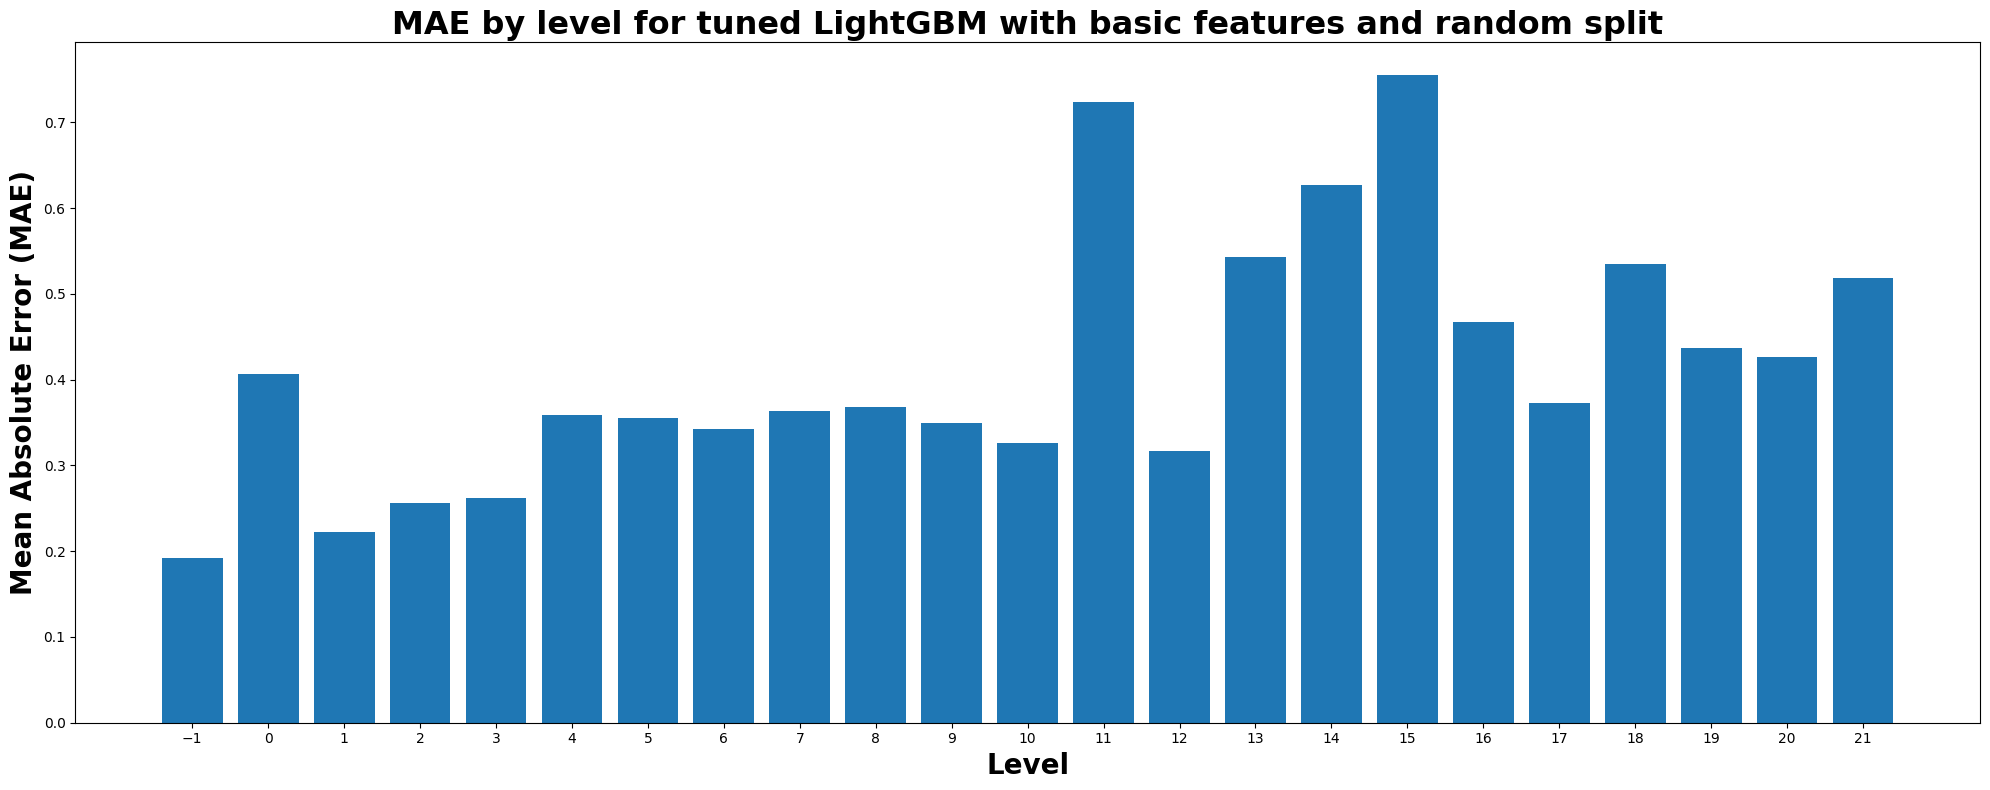

In [44]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [45]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.30

Round type: 0.5
RMSE: 0.32

Round type: 0.33
RMSE: 0.34

Round type: 0.45
RMSE: 0.32



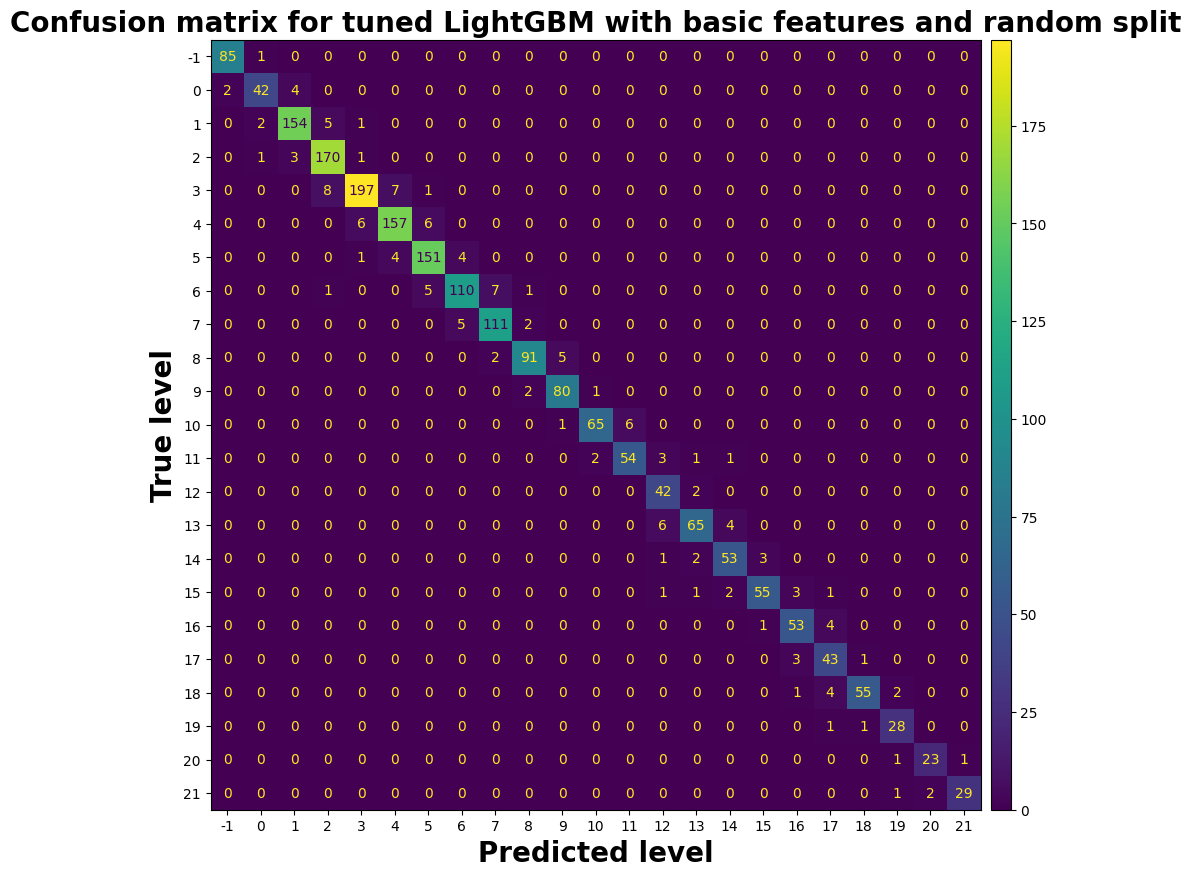

In [46]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [47]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.758611,0.447891
1,chronological,Optuna,basic,0.747894,0.452643
2,random,default,basic,0.568104,0.368391
3,random,Optuna,basic,0.553580,0.358064


In [48]:
from training.results import plot_summary

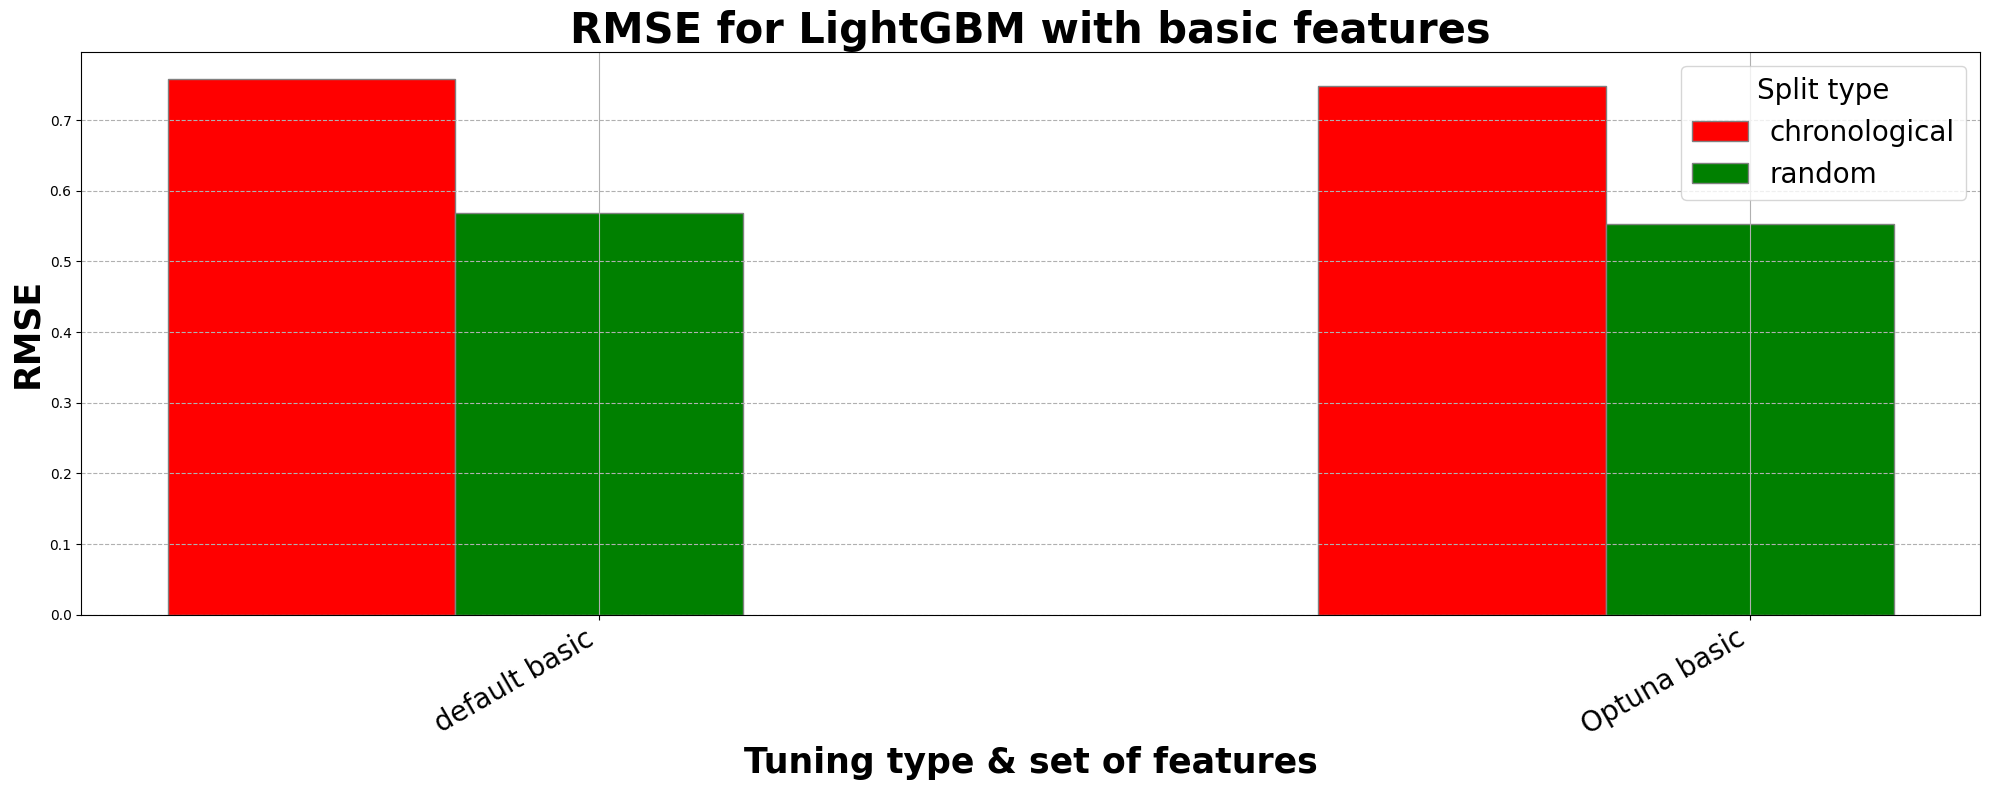

In [49]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

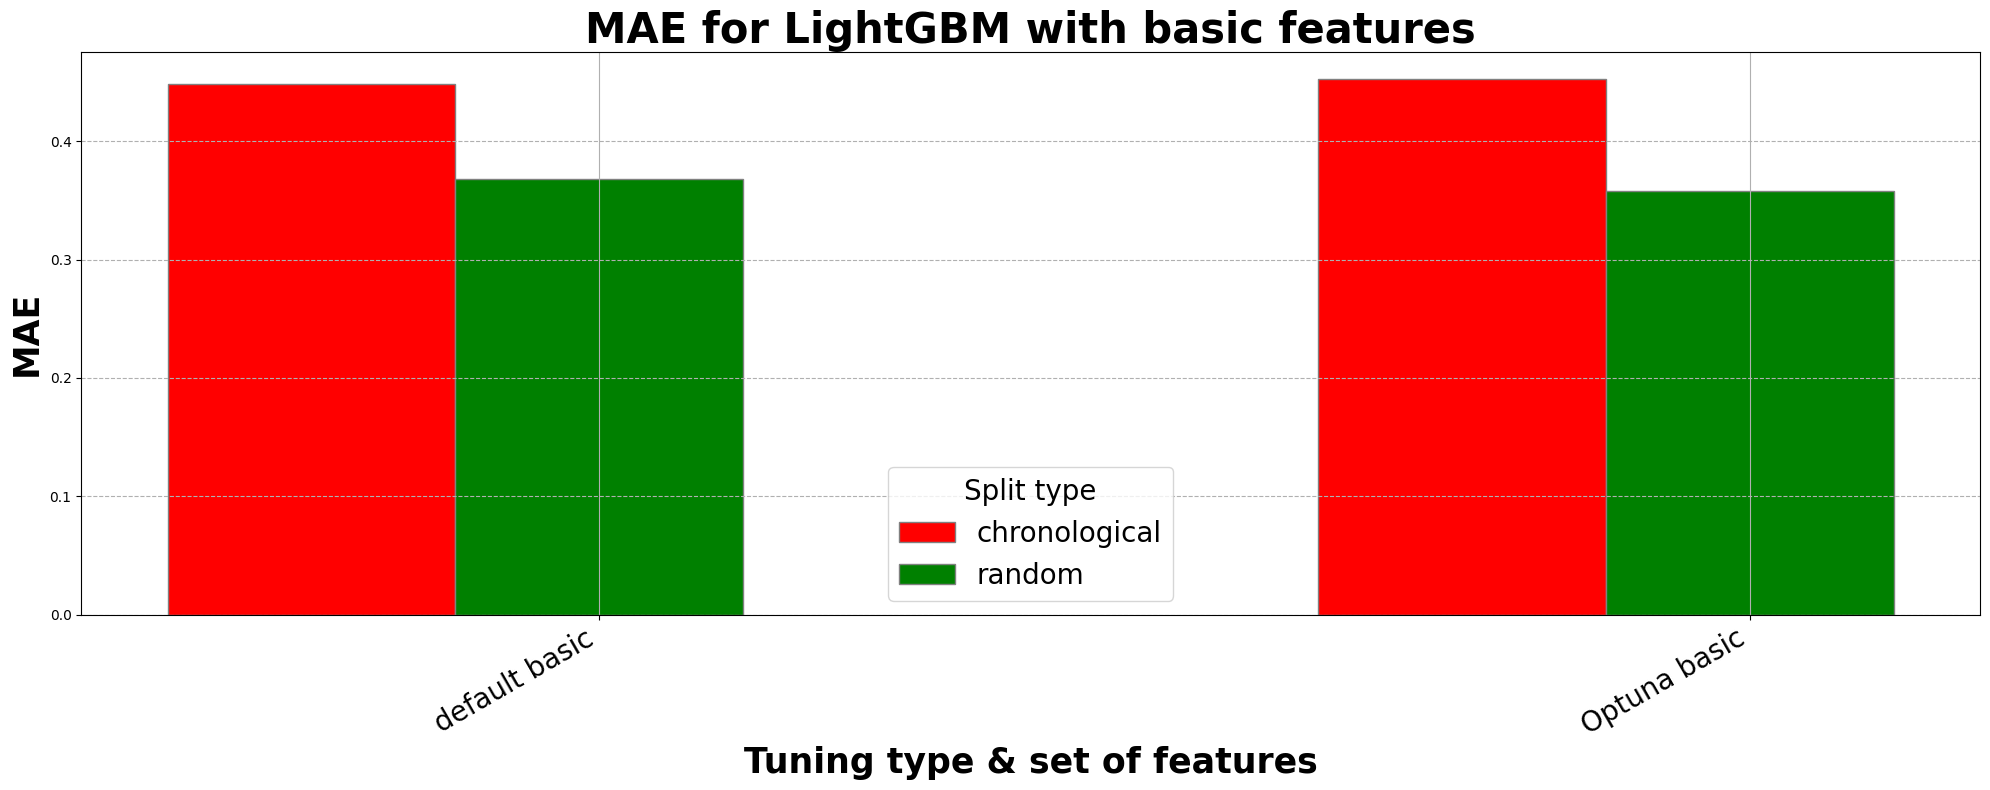

In [50]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [51]:
results.to_csv("./lightgbm_basic_results.csv")